In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib as mat
import matplotlib.pyplot as plt

from matplotlib.patches import Rectangle
from IPython.display import IFrame
import scipy.stats as stats

In [2]:
### use command line to
### retrieve a list of all CUMTD txt files and 
### save the list as a text file named cumtd_allfiles.txt at the directory "~/work"

### if open this notebook on server, use this line:
#!ls ~/work/data-readonly/CUMTD/ > ~/work/cumtd_allfiles.txt

### if open this notebook locally, read from your local files, for example:
!ls ./google_transit > ./cumtd_allfiles.txt

### retrieve file_allfiles.txt
file_list = pd.read_csv('cumtd_allfiles.txt', header = None)

### convert the pandas Series to an actual python list, the elements of which are strings
file_list = file_list[0].tolist()

### see what's in this file_list?
for file in file_list:
    print(file)

agency.txt
calendar.txt
calendar_dates.txt
fare_attributes.txt
fare_rules.txt
routes.txt
shapes.txt
stop_times.txt
stops.txt
trips.txt


In [3]:
# now iteratively read in all the CUMTD txt files

# save all the data in a dictionary named 'data', 
# each entry of the dict is a pandas DataFrame
data = {}

for file in file_list:
    data[file.replace(".txt","")] = pd.read_csv('~/google_transit/' + file)

In [4]:
data.keys()

dict_keys(['routes', 'agency', 'shapes', 'fare_rules', 'stops', 'stop_times', 'trips', 'calendar', 'calendar_dates', 'fare_attributes'])

In [5]:
len(data["stop_times"]["trip_id"].unique())

5498

In [6]:
data["calendar_dates"]["date"].unique().min()


20161218

In [7]:
data["fare_rules"]["fare_id"]

0      NORMAL
1       ISTOP
2      NORMAL
3       ISTOP
4      NORMAL
5       ISTOP
6      NORMAL
7      NORMAL
8       ISTOP
9      NORMAL
10     NORMAL
11     NORMAL
12     NORMAL
13      ISTOP
14      ISTOP
15     NORMAL
16      ISTOP
17     NORMAL
18      ISTOP
19      ISTOP
20     NORMAL
21      ISTOP
22     NORMAL
23     NORMAL
24      ISTOP
25     NORMAL
26     NORMAL
27     NORMAL
28     NORMAL
29     NORMAL
        ...  
72     NORMAL
73     NORMAL
74      ISTOP
75     NORMAL
76     NORMAL
77      ISTOP
78     NORMAL
79      ISTOP
80      ISTOP
81      ISTOP
82     NORMAL
83     NORMAL
84      ISTOP
85      ISTOP
86     NORMAL
87     NORMAL
88     NORMAL
89      ISTOP
90      ISTOP
91      ISTOP
92      ISTOP
93     NORMAL
94      ISTOP
95     NORMAL
96     NORMAL
97     NORMAL
98      ISTOP
99      ISTOP
100    NORMAL
101     ISTOP
Name: fare_id, dtype: object

# 1.Overall


In [8]:
def get_stop_latlon(stop):
    match = data['stops']['stop_id'] == stop
    stop_lat = data['stops'][match]['stop_lat'].values[0]
    stop_lon = data['stops'][match]['stop_lon'].values[0]
    return stop_lon, stop_lat

In [9]:
get_stop_latlon("LSE:8")

(-88.20802999999998, 40.111647999999995)

## Plot in Google map (Both scatter plot and heatmap)
    The plot will be in the "scatter.html" and "heatmap.html"
    ???Shall we show the pic here? (Maybe use some technique that could capture screenshot from web?)

In [54]:
import gmplot
gmap = gmplot.GoogleMapPlotter(40.088, -88.281, 16)
gmap.heatmap(data["stops"]["stop_lat"], data["stops"]["stop_lon"])
gmap.draw("heatmap.html")

In [56]:
IFrame('heatmap.html', width=700, height=350)

In [25]:
import gmplot
gmap = gmplot.GoogleMapPlotter(40.088, -88.281, 16)
gmap.scatter(data["stops"]["stop_lat"], data["stops"]["stop_lon"],'ee6481', size=40, marker=False)
gmap.draw("scatter.html")


In [60]:
IFrame('scatter.html', width=700, height=350)

## Density plot

/Users/beibri/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


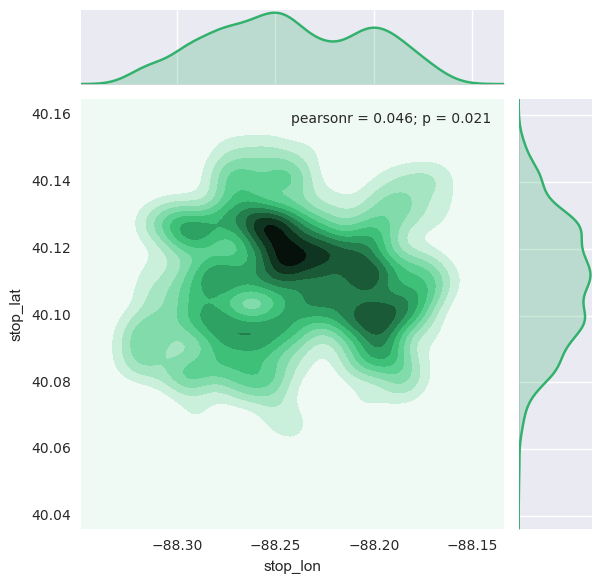

In [11]:
import seaborn as sns
stops=data["stops"]
ax=sns.jointplot(x="stop_lon",y='stop_lat',data=stops,kind="kde", color="#32b16c")

In [10]:
class Dataset:
    def __init__(self, data):
        self.data = data
        
    def convert(self, column, dtype):
        self.data[column] = np.array(self.data[column], dtype=dtype)
        
    def stats(self):
        statistics = {}
        for key in self.data:
            if self.data[key].dtype not in ("float", "int"):
                continue
            values = self.data[key]
            statistics[key] = (values.min(), values.max(), values.std(), values.mean())
        return statistics
    
    def filter_eq(self, column, value):
        good = (self.data[column] == value)
        new_data = {}
        for column in self.data:
            new_data[column] = self.data[column][good]
        return Dataset(new_data)
    
    def filter_lt(self, column, value):
        good = (self.data[column] < value)
        new_data = {}
        for column in self.data:
            new_data[column] = self.data[column][good]
        return Dataset(new_data)
    
    def filter_gt(self, column, value):
        good = (self.data[column] > value)
        new_data = {}
        for column in self.data:
            new_data[column] = self.data[column][good]
        return Dataset(new_data)
    
    def size(self):
        for key in self.data:
            return self.data[key].size
    
dataset = Dataset(data["stops"])


TypeError: set_ticklabels() got an unexpected keyword argument 'colors'

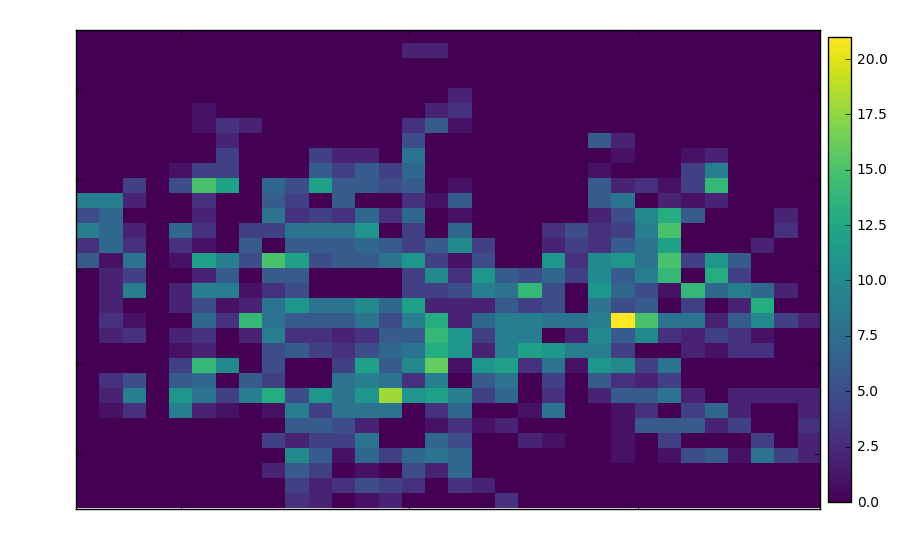

In [26]:


stats=dataset.stats()
lon_min=stats["stop_lon"][0]
lon_max=stats["stop_lon"][1]
lat_min=stats["stop_lat"][0]
lat_max=stats["stop_lat"][1]
num_bins=32
lon=np.mgrid[lon_min:lon_max:(num_bins+1)*1j]
lat=np.mgrid[lat_min:lat_max:(num_bins+1)*1j]
stops_count=np.zeros((num_bins,num_bins))
for i in range(num_bins):
    left_lat=lat[i]
    right_lat=lat[i+1]
    filter_lat_left=dataset.filter_gt("stop_lat",left_lat)
    filter_lat_right=filter_lat_left.filter_lt("stop_lat",right_lat)
    for j in range(num_bins):
        left_lon=lon[j]
        right_lon=lon[j+1]
        filter_lon_left=filter_lat_right.filter_gt("stop_lon",left_lon)
        filter_lon_right=filter_lon_left.filter_lt("stop_lon",right_lon)
        stops_count[i,j]+=filter_lon_right.size()
        
plt.imshow(stops_count,extent=(lon_min,lon_max,lat_min,lat_max),cmap=plt.cm.viridis,interpolation="nearest")
plt.title("STOPS DENSITY of CU MTD",color="white")
plt.xlabel("LONGITUDE",color="white")
plt.xticks(color="white")
plt.ylabel("LATITUDE",color="white")
plt.yticks(color="white")
cb=plt.colorbar(fraction=0.03, pad=0.01)
cb.set_ticklabels(colors="white")
plt.savefig('demo.png', transparent=True)


# 2. Stops and Trips

In [29]:
data["stop_times"].head()

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type
0,[@14.0.51708725@][4][1277756770140]/0__T4_UIMF,07:25:00,07:25:00,DEPOT:1,0,WEST - ILLINOIS TERMINAL,0,0
1,[@14.0.51708725@][4][1277756770140]/0__T4_UIMF,07:35:00,07:35:00,PAR:2,2,WEST - ILLINOIS TERMINAL,0,0
2,[@14.0.51708725@][4][1275505811421]/0__T4_UIMF,07:35:00,07:35:00,PAR:2,0,WEST - ILLINOIS TERMINAL,0,0
3,[@14.0.51708725@][4][1275505811421]/0__T4_UIMF,07:36:35,07:36:35,PAMD:2,1,NaN,0,0
4,[@14.0.51708725@][4][1275505811421]/0__T4_UIMF,07:37:48,07:37:48,PSL:2,2,NaN,0,0


In [51]:
tripscount=data["stop_times"].groupby("trip_id").count()
tripssort=tripscount.sort("stop_id",ascending=False)
tripssort["stop_id"].max()

/Users/beibri/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


147

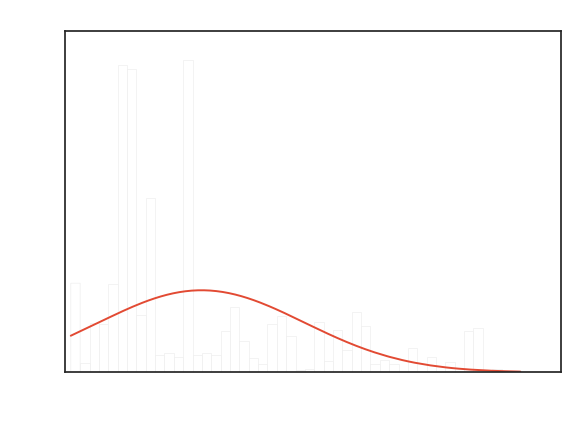

In [52]:
from scipy.stats import norm
trip_list=tripssort["stop_id"].tolist()
plt.hist(trip_list,bins=48,normed=True,color="white")

plt.style.use('seaborn-white')
plt.title("Distribution of Stops Number in Trips",color="white")
plt.xlabel("Number of Stops in Trips",color="white")
plt.xticks(color="white")
plt.ylabel("Proportion",color="white")
plt.yticks(color="white")

fit = norm.pdf(trip_list, np.mean(trip_list), np.std(trip_list))  
plt.plot(trip_list,fit,'-')
plt.savefig('trips.png', transparent=True)

# title lable

# 3. Choose top 10 busiest stops 

In [53]:
from collections import Counter
stopid=data["stop_times"]["stop_id"]
word_counts = dict(Counter(stopid))
top_ten=dict(Counter(word_counts).most_common(10))
top_ten_keys=top_ten.keys()

In [54]:
top_ten_keys

dict_keys(['IU:1', 'IU:2', 'LSE:8', 'ARYWRT:3', 'PLAZA:4', 'WRTCHAL:4', 'IT:5', 'GRNMAT:1', 'GRNMAT:3', 'PAR:2'])

In [55]:
top_ten_sorted = sorted(top_ten.items(), key=lambda x: x[1],reverse=True)
print (top_ten_sorted)

[('PAR:2', 1732), ('IU:1', 1674), ('GRNMAT:3', 1660), ('IU:2', 1629), ('GRNMAT:1', 1617), ('ARYWRT:3', 1451), ('IT:5', 1317), ('PLAZA:4', 1292), ('LSE:8', 1286), ('WRTCHAL:4', 1247)]


In [56]:
stops=data["stops"]
top10data=stops.loc[stops['stop_id'].isin(top_ten_keys)]

In [57]:
def sort_list(top_ten_sorted):
    sortlist=[]
    for t in top_ten_sorted:
        t0=t[0]
        sortlist.append(t0)
    return sortlist

In [58]:
sortlist=sort_list(top_ten_sorted)

In [59]:
def get_stop_name(stop):
    match = data['stops']['stop_id'] == stop
    stop_name = data['stops'][match]['stop_name'].values[0]
    return stop_name

In [60]:

def stop_name_list(top_ten_keys):
    stoplist=[]
    for i in top_ten_keys:
        selected=get_stop_name(i)
        stoplist.append(selected)
    return stoplist

In [61]:
sortname=stop_name_list(sortlist)
print (sortname)

['PAR (North Side Shelter)', 'Illini Union (South Side Shelter)', 'Green & Mathews (SW Corner)', 'Illini Union (Engineering Side)', 'Green & Mathews (NE Corner)', 'Armory & Wright (South Side)', 'Illinois Terminal (Platform C)', 'Transit Plaza (SE Platform)', 'Lincoln Square Garage South', 'Wright & Chalmers (NW Corner)']


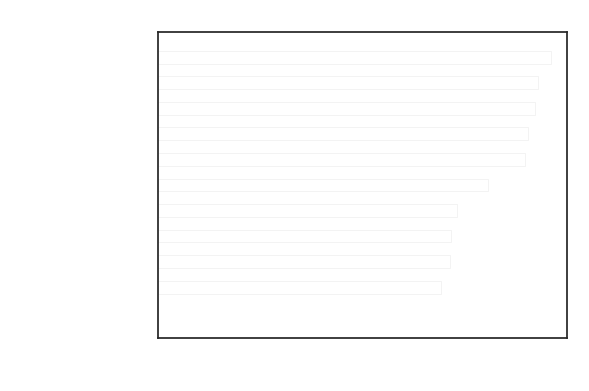

In [86]:
plt.rcParams["figure.figsize"] = (6, 4)
plt.barh(range(len(top_ten)), [t[1] for t in top_ten_sorted][::-1], align='center',color="white",height=0.5)
plt.yticks(range(len(top_ten)), sortname[::-1],fontsize=7)
plt.title("Top 10 busiest stops",color="white")
plt.xlabel("Trips Number of Each Stops",color="white")
plt.xticks(color="white")
plt.tight_layout()
plt.yticks(color="white")
plt.savefig('stops.png', transparent=True)

## Shows the top 10 popular stops in the scatterplot

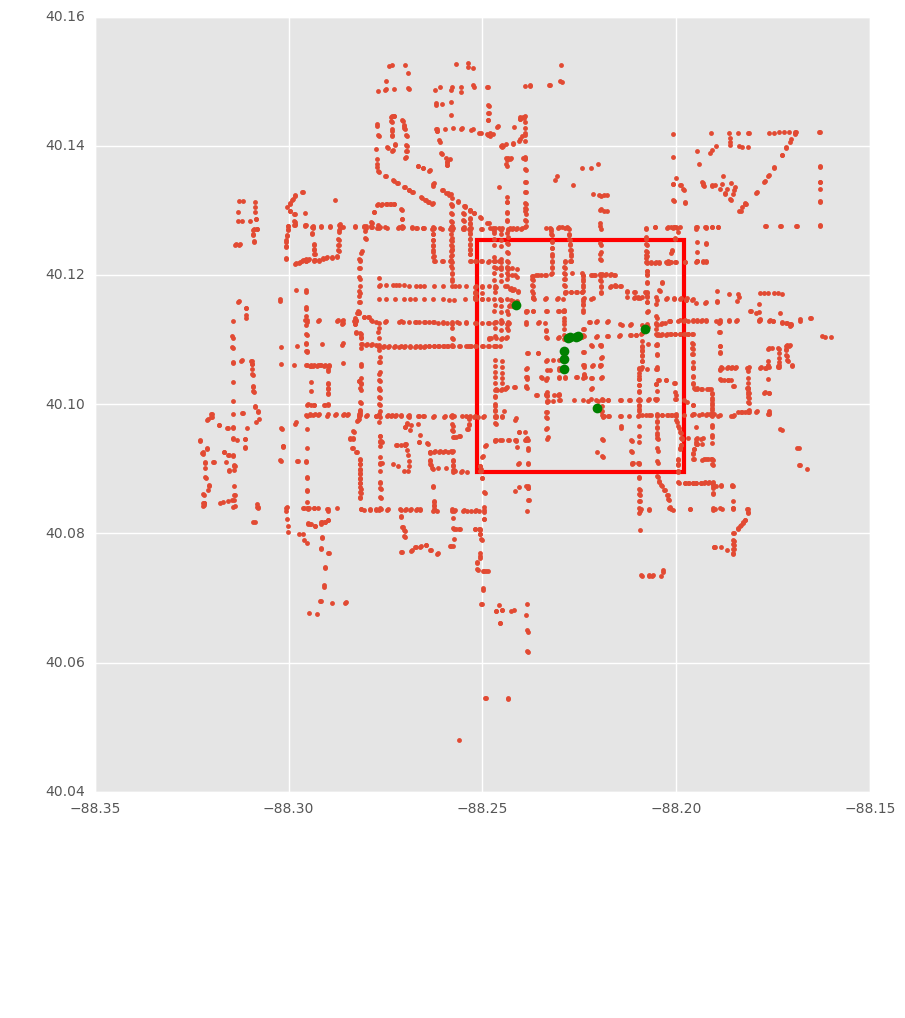

In [50]:
plt.figure(figsize=(10, 10))

ax1 = plt.subplot(1,1,1)
ax1.plot(data["stops"]["stop_lon"],data["stops"]["stop_lat"],".")
ax1.plot(top10data["stop_lon"],top10data["stop_lat"],"go")
ax1.annotate("PAR (North Side Shelter)",
            xy=(40.09949000000001,-88.220416), xycoords='data')

min_lon10=top10data["stop_lon"].min()
max_lon10=top10data["stop_lon"].max()
min_lat10=top10data["stop_lat"].min()
max_lat10=top10data["stop_lat"].max()
lat_width=(max_lat10-min_lat10)+0.02
lon_width=(max_lon10-min_lon10)+0.02
lon_left10=min_lon10-0.01
lon_right10=max_lon10+0.01
lat_left10=min_lat10-0.01
lat_right10=max_lat10+0.01

ax2 = plt.subplot(1,1,1)
ax2.add_patch(Rectangle((min_lon10-0.01, min_lat10-0.01), lon_width, lat_width,alpha=1,edgecolor="red",fill=False,linewidth=3))


plt.show()
#circle the middle area
#zoom in the stops


In [47]:
lon_left10

-88.251442000000011

In [48]:
zoomindata=stops.loc[(stops['stop_lon']>lon_left10)&(stops['stop_lon']<lon_right10)&(stops['stop_lat']>lat_left10)&((stops['stop_lat']<lat_right10))]

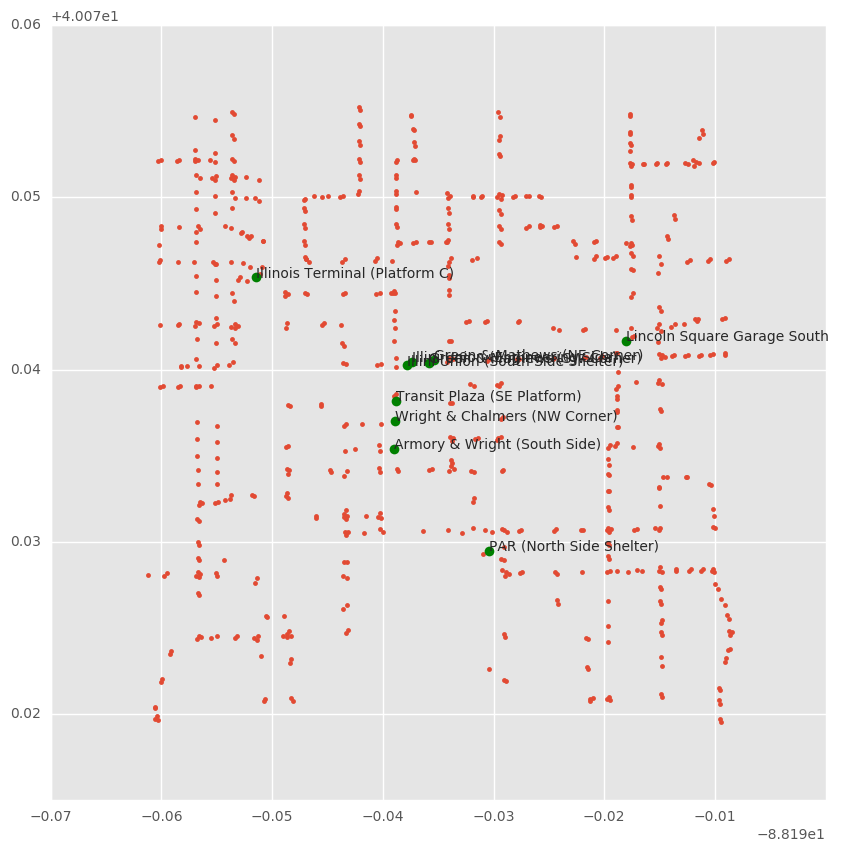

In [49]:
plt.plot(zoomindata["stop_lon"],zoomindata["stop_lat"],".")
plt.plot(top10data["stop_lon"],top10data["stop_lat"],"go")

for i in top_ten_keys:    
    plt.annotate(get_stop_name(i), xy=get_stop_latlon(i))

